In [207]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import folium 
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import re
import glob
import seaborn as sns; sns.set()
from PIL import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from numpy import unravel_index
import nltk
from nltk.collocations import *

# **Create Data** 
### We began by creating our own data from the given csv files. Αlso we added an extra attribute that we called it "Month" to 
### to distinguish one data frame from the other

In [208]:
columns = ['id','zipcode','transit','bedrooms','beds','review_scores_rating','number_of_reviews_ltm',
'neighbourhood',
'name','latitude','longitude','last_review','instant_bookable','host_since','host_response_rate',
'host_identity_verified','host_has_profile_pic','first_review','description','city','cancellation_policy',
'bed_type','bathrooms','accommodates','amenities','room_type','property_type','price','availability_365',
'minimum_nights','month']

df = pd.read_csv('./data/febrouary/listings.csv',index_col = False,low_memory = False)
February = pd.DataFrame(data = df,columns = columns)
February.month = 'February'

df = pd.read_csv('./data/april/listings.csv',index_col = False,low_memory = False)
April = pd.DataFrame(data = df, columns = columns)
April.month = 'April'

df = pd.read_csv('./data/march/listings.csv',index_col = False,low_memory = False)
March = pd.DataFrame(data = df, columns = columns)
March.month = 'March'


# **Cleaning Data**
### In this step we concatenated the csvs to create a new data frame with the useful data to begin with the analysis. 
### Lets call it "train" data frame. 

In [209]:
#cleaning 
temp = pd.concat([April,March,February],ignore_index = True)
train = temp.sort_values(by='id')

train['transit'].fillna("No transit", inplace = True) 
train['description'].fillna("No description", inplace = True) 
train['neighbourhood'].fillna("No neighbourhood", inplace = True) 
train['name'].fillna("No name", inplace = True) 
train['price'].fillna("No price", inplace = True) 
train['zipcode'] =train['zipcode'].str.replace(' ','')

train['price'] = train['price'].map(lambda x: x.lstrip('$'))
train['price'] = train['price'].str.replace(',','')
train['price'] = pd.to_numeric(train['price'])


# **Most common room type**
### We have created a new data frame that keeps information about how many times a room type appears in the  train data frame.
### So, our  goal is to extract which room type appears the most in the train frame and plot it in a diagram.
### To achieve this , we grouped the  train frame by  the room type and with the help of nunique() we count the apperances

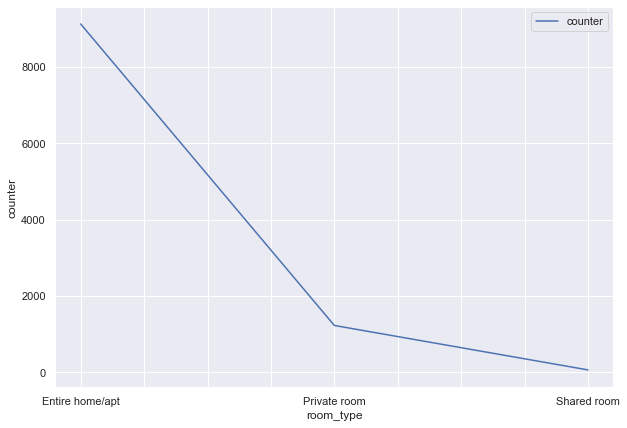

In [210]:
query1 = train.groupby('room_type')['id'].nunique().to_frame().reset_index()
query1 = query1.rename(columns = {"id" : "counter"})
query1.sort_values(ascending = False, inplace = True, by='counter')
query1.plot(y = 'counter', x = 'room_type', kind = 'line')
plt.ylabel('counter')
plt.xlabel('room_type')
plt.show()


# **Graph** 
### Here is the course of the price  depending on the months February, March and April
### To do this we grouped the months and we calculated the mean value of the prices.

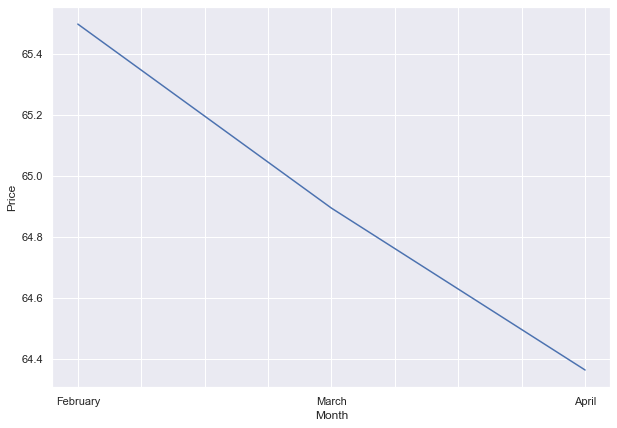

In [211]:
query2 = train.groupby('month')['price'].mean()
query2.sort_values(ascending=False, inplace = True)
query2.plot(y = 'price', x = 'month',kind = 'line')
plt.ylabel('Price')
plt.xlabel('Month')
plt.show()

# What are the top 5 neighborhoods with the most reviews?

### Again we grouped the train frame by neighbourhoods and we took the summation of the number of reviews column of each neighbourhood.

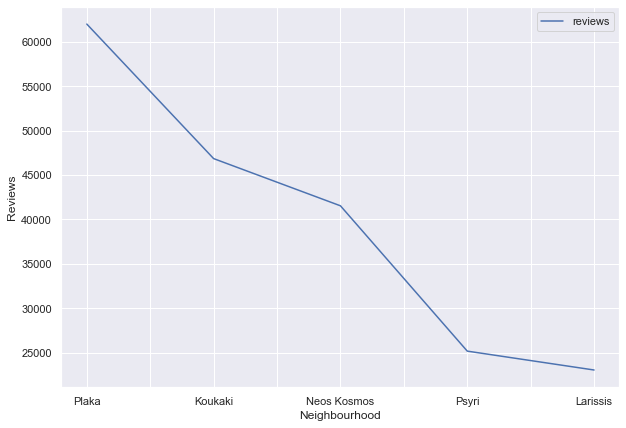

In [212]:
query3 = train.groupby('neighbourhood')['number_of_reviews_ltm'].sum()
query3.sort_values(ascending= False, inplace = True)
query3 = query3.to_frame().reset_index().rename(columns = {"number_of_reviews_ltm" : "reviews"})
query3 = query3.nlargest(5,'reviews')
#query1.sort_values(ascending = False, inplace = True, by='counter')
query3.plot(y = 'reviews', x = 'neighbourhood', kind = 'line')
plt.ylabel('Reviews')
plt.xlabel('Neighbourhood')
plt.show()

# What is the neighborhood with the most real estate listings?
### Similarly, we grouped the train frame by neighbourhoods and we counted the uniquely id's.

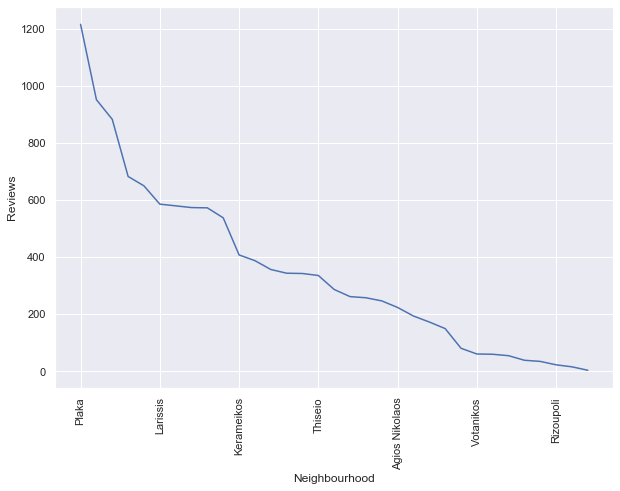

In [213]:
query4 = train.groupby('neighbourhood')['id'].nunique() 
query4.sort_values(ascending= False, inplace = True)
query4.plot(y = 'neighbourhood', x = 'id', kind = 'line')
plt.ylabel('Reviews')
plt.xticks(rotation='vertical')
plt.xlabel('Neighbourhood')
plt.show()

# How many entries take place per neighborhood and per month?
### Nothing important to mention. We followed the same reasoning.

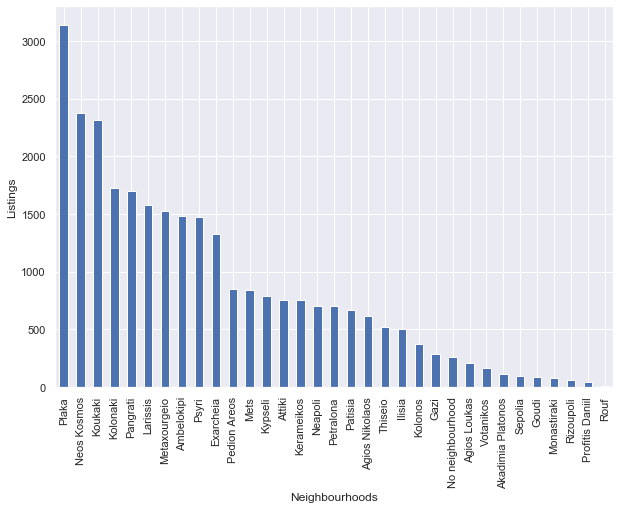

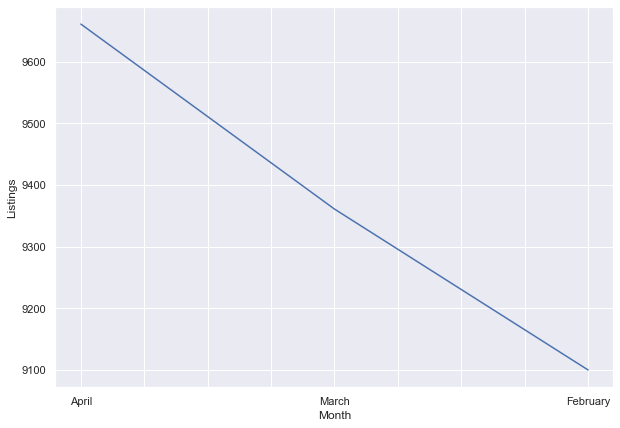

In [214]:
query5 = train.groupby('neighbourhood')['id'].count()
#query5 = query5.rename(columns = {"id" : "listings"})
query5.sort_values(ascending= False, inplace = True)
query5.plot(y = 'neighbourhood', x = 'id', kind = 'bar')
plt.ylabel('Listings')
#plt.xticks(rotation='vertical')
plt.xlabel('Neighbourhoods')
plt.show() 
query5 = train.groupby('month')['id'].count()
query5.sort_values(ascending= False, inplace = True)
query5.plot(y = 'month', x = 'id', kind = 'line')

plt.ylabel('Listings')
#plt.xticks(rotation='vertical')
plt.xlabel('Month')
plt.show()

# Plotting a histogram that shows the real estate listings per neighbourhood.

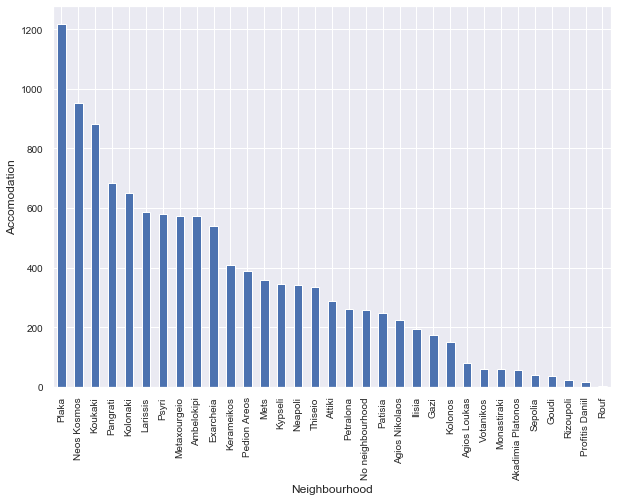

In [215]:
query6 = train.groupby('neighbourhood')['id'].nunique() 
query6.sort_values(ascending = False).plot.bar(fontsize = 10)
query6 = query6.sort_values(ascending = False)
plt.ylabel('Accomodation')
plt.xlabel('Neighbourhood')
plt.rcParams["figure.figsize"] = [12, 8];
plt.show()

# What is the most common type of room in each neighborhood?

### We did this by following the same reasoning but we plotted  using a heatmap.

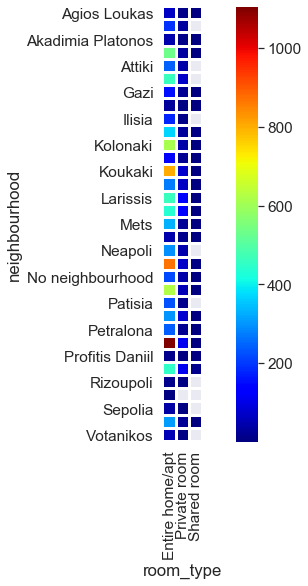

In [216]:
query7 = train.groupby(['neighbourhood','room_type'])['id'].nunique()
query7 = query7.to_frame().rename(columns = {"id" : 'counter'}).reset_index().sort_values(by = 'counter',ascending = False)
sns.set(font_scale=1.4)
result = query7.pivot(index='neighbourhood', columns='room_type', values='counter')
sns.heatmap(result, annot=False, fmt="d", cmap='jet',linewidths=2,square = True)
plt.show()

# What is the most expensive type of room?
### Nothing to mention. We followed the same reasoning again.

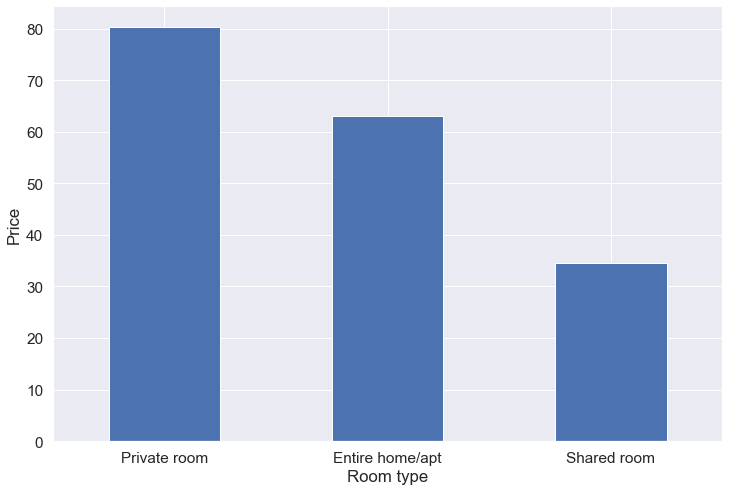

In [217]:
query8 = train.groupby(['room_type'])['price'].mean()
query8 = query8.sort_values(ascending = False)
#query1.sort_values(ascending = False, inplace = True, by='counter')
query8.plot(y = 'room_type', x = 'price', kind = 'bar')
plt.xticks(rotation='horizontal')
plt.ylabel('Price')
plt.xlabel('Room type')
plt.show()

# Creating a map that shows the location of each real estate listing.
### We took the latitude and longitude  of each listing and we placed it in a data frame. 
### Then, for each location we've created a pop-up that shows the room type of the listing using folium.Marker.

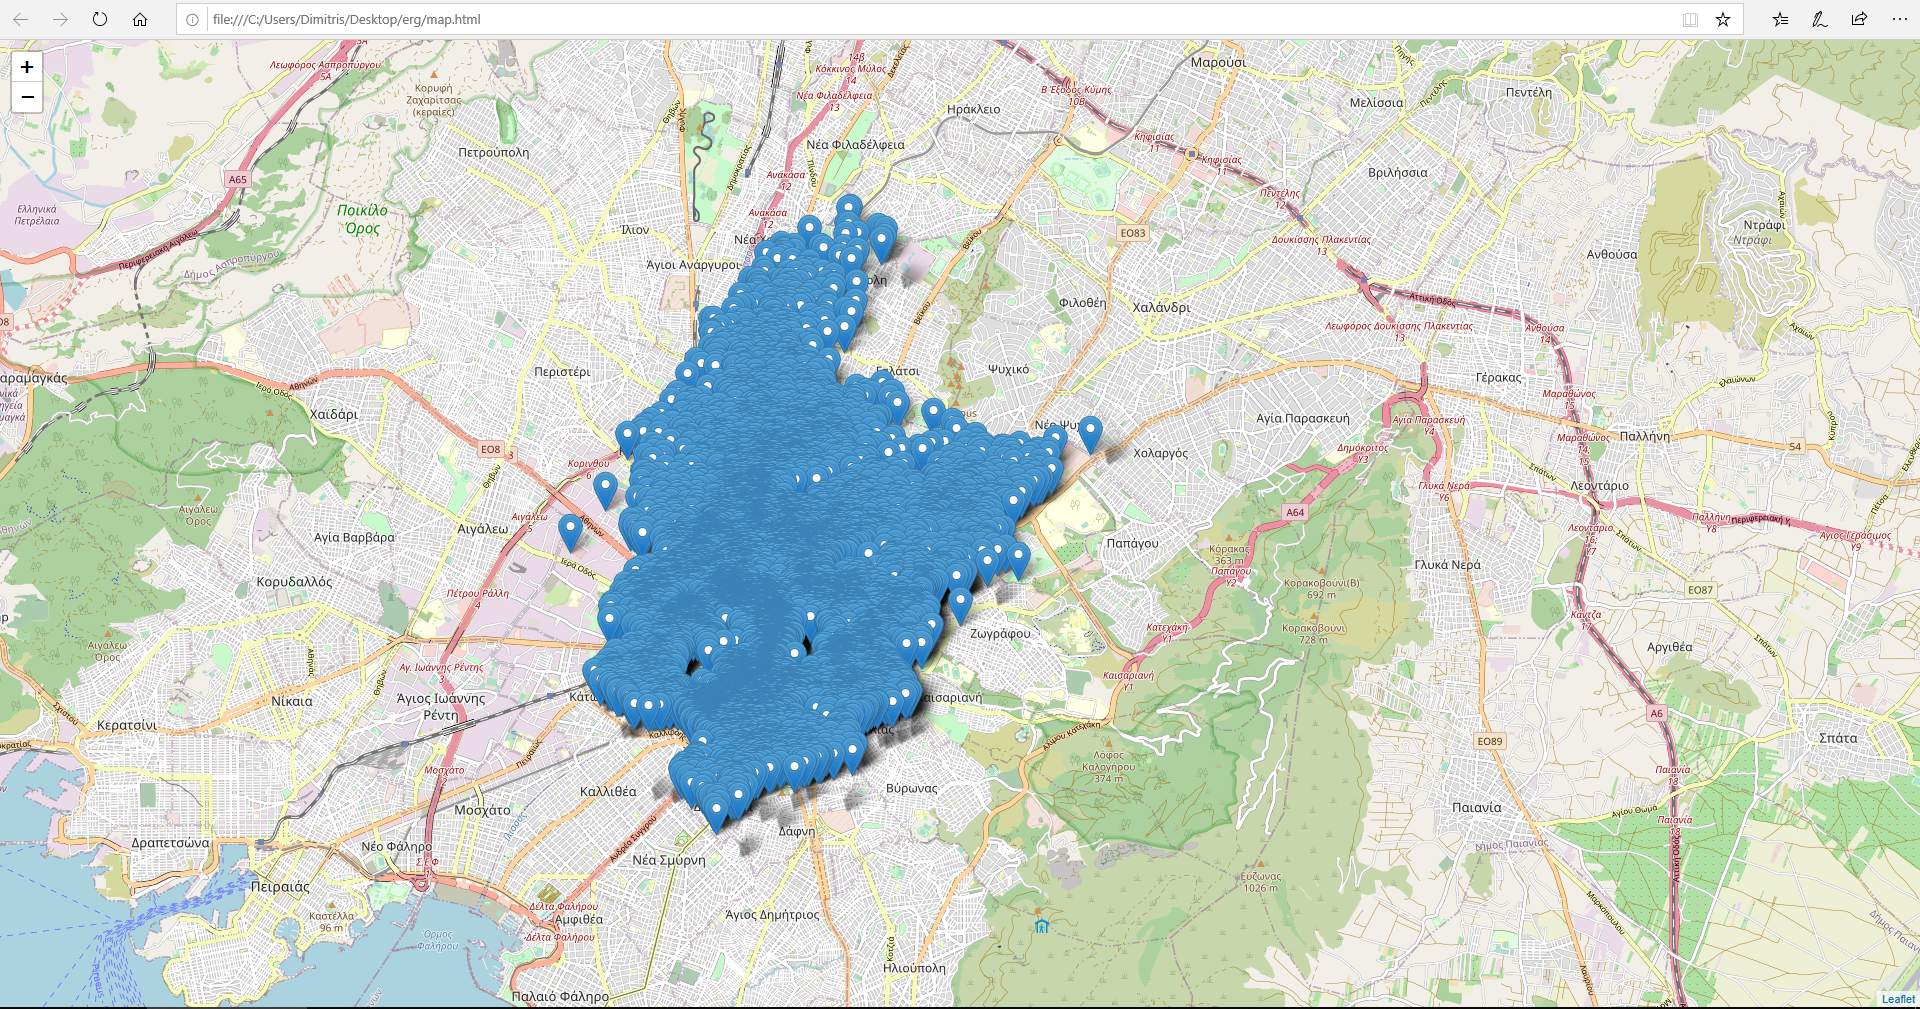

In [218]:
 query9 = train[['latitude','longitude','month','room_type']]
 query9 = query9.loc[query9['month'] == 'April']
 df_counters = query9
 query9 = query9[['latitude','longitude']]
 locationlist = query9.values.tolist()
 
 map = folium.Map(location=locationlist[0], zoom_start=12)
 for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df_counters['room_type'][point]).add_to(map)
 #map.save("map.html") ## you can open the html to see the locations.
Image.open(r'map.png')

# Wordcloud creation.
### Just using the frame with the appearances of each neighbourhoods from the previous query.
### This is a wordcloud using neighbourhoods column.

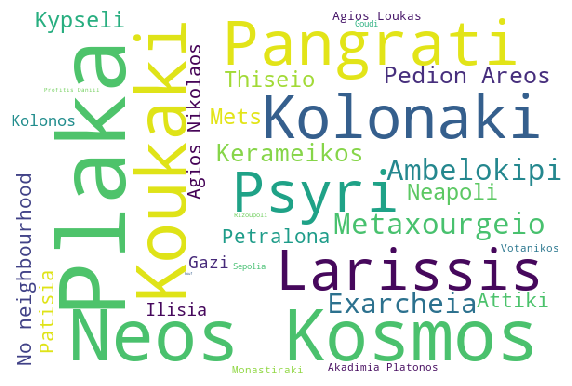

In [219]:
wordcloud = WordCloud(background_color="white", max_font_size=100,width = 600 , height = 400)
wordcloud = wordcloud.fit_words(query6)
plt.rcParams["figure.figsize"] = [10, 7];
plt.axis("off")
plt.imshow(wordcloud)
plt.show()

### Wordcloud using description column fro train frame.

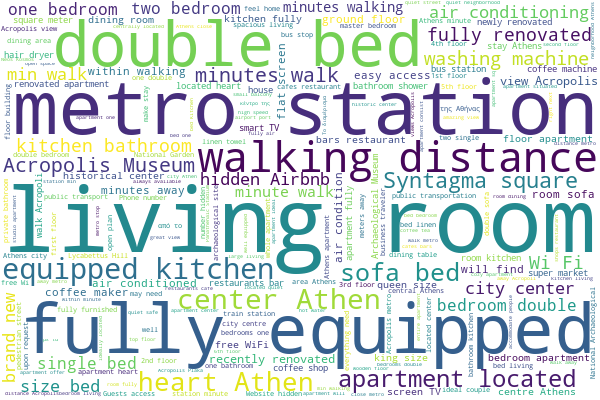

In [220]:
description_wordcloud = WordCloud(background_color="white", max_font_size=200,width = 600 , height = 400).generate(' '.join(train['description']))
img = description_wordcloud.to_image()
img

### This is a wordcloud using last review column
### In this step we took from tha train frame the last_review column  and we matched it with the reviews.csv file to find the last review.

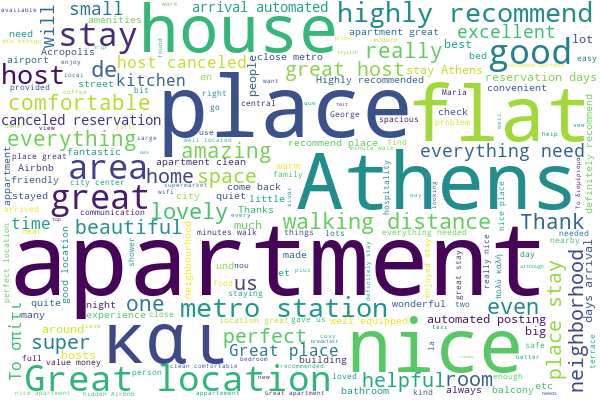

In [221]:

df1 = pd.read_csv('./data/febrouary/reviews.csv',index_col = False,low_memory = False)
april_reviews = pd.DataFrame(data = df1,columns = ['listing_id','comments','date'])

df1 = pd.read_csv('./data/april/reviews.csv',index_col = False,low_memory = False)
february_reviews = pd.DataFrame(data = df1,columns = ['listing_id','comments','date'])

df1 = pd.read_csv('./data/march/reviews.csv',index_col = False,low_memory = False)
march_reviews = pd.DataFrame(data = df1,columns = ['listing_id','comments','date'])

reviews = pd.concat([april_reviews,march_reviews,february_reviews],ignore_index = True)

reviews = reviews.rename(columns = {"listing_id" : "id"})
reviews = reviews.rename(columns = {"date" : 'last_review'})



mergedStuff = pd.merge(reviews, train, on=['id','last_review'] , how='inner')
mergedStuff = mergedStuff.drop_duplicates(subset='id', keep="first")
mergedStuff['comments'].fillna("No comments", inplace = True) 

review_wordcloud = WordCloud(
    background_color="white", max_font_size=100,
    width = 600 , height = 400, 
    normalize_plurals = False).generate(' '.join(mergedStuff['comments']))

img = review_wordcloud.to_image()
img

### Wordcloud using transit column from the train file

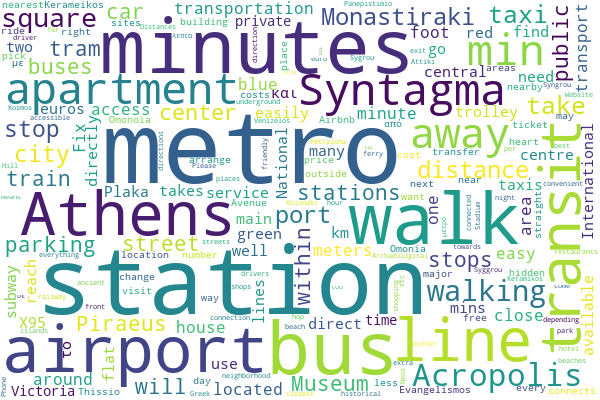

In [222]:

wordcloud2 = WordCloud(background_color="white", max_font_size=100,
    width = 600 , height = 400, 
    normalize_plurals = False, collocations = False).generate(' '.join(train['transit']))
img = wordcloud2.to_image()
img

# Which month had the most reviews?

In [223]:
plt.close('all')
#poios mhna eixame tis perissoteres kritikes.
query10 = train.groupby(['month'])['number_of_reviews_ltm'].sum()
query10 = query10.sort_values(ascending = False)
query10.head(1).to_frame().reset_index().rename(columns = {"number_of_reviews_ltm" : 'reviews'})

month  reviews
0  April   138148

# What is the most expensive listing?

In [224]:
#poio kataluma einai to pio akrivo

query11 = train.iloc[train['price'].argmax()][['id','price','neighbourhood']]
query11.head().to_frame().T

id price neighbourhood
16940  28969842  7000   Neos Kosmos

## In this step we add the option max_words = 20. So the wordcloud shows the 20 most common words that appear in the description section in the train frame. Also we removed the stop words from there.

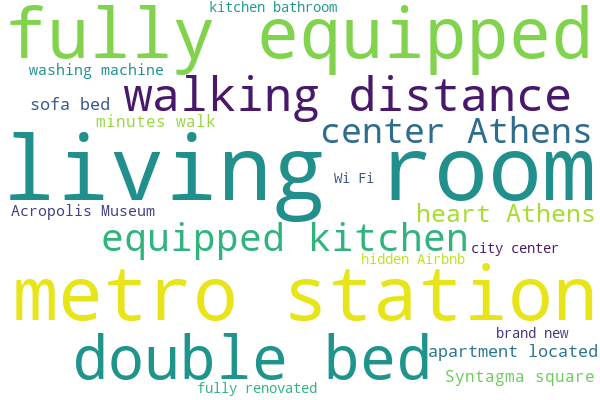

In [225]:
description_wordcloud_stop = WordCloud(
    stopwords=STOPWORDS,background_color="white", 
    max_font_size=100,width = 600 ,
    height = 400,
    max_words = 20,normalize_plurals = False).generate(' '.join(train['description']))

img = description_wordcloud_stop.to_image()
img

### Here we created a new data frame that contains  the  concatanation of the columns : name, description
### From the column  description we removed the stopwords and  the useless information and we removed the capitalization. 
### Also using the tfidVectorizer and the option (ngram_range=(1, 2)) we created bigrams and unigrams arrays  from the concatenation column.
### Using cosine_similarity(x) we created an array . Each  cell of this array contains a factor that help us to understand how similar  two listing_descriptions are.
### From this array we filled the diagonal with zeros. Cause the cosine_similarity(x)  fills the diagonal with 1
### After this we extracted  the max 100 times. We did this cause we want  the 100 most similar listings.
### In each step we filled the cell that the max occured and its opposite.  For exmp. if max_cell= [0,1] then we fil it with zero . We do the same at the [1,0] cell.

In [226]:
last  = pd.DataFrame(train[['id','name','description']]).drop_duplicates(subset = "id").reset_index()
temp = pd.DataFrame(train[['id','name','description']])
#clean = pd.DataFrame(transit.items(), columns=['id','name','description']
stop = stopwords.words('english')

last['description'] = last['description'].str.lower()
last['name'] = last['name'].str.lower()

last['description'] = last['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
last['name'] = last['name'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

last['name']= last['name'].map(lambda x: re.sub(r'\W+', ' ', x))
last['description']= last['description'].map(lambda x: re.sub(r'\W+', ' ', x))
last['concat'] = last['name'].map(str)  + ' ' + last['description'].map(str)

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
x = vectorizer.fit_transform(last['concat'])  
y = cosine_similarity(x)
array = y
np.fill_diagonal(y,0)
similarity = {}
for i in range(0,100):
     temp = unravel_index(array.argmax(),array.shape)
     array[temp[0]][temp[1]]  = 0
     array[temp[1]][temp[0]]  = 0
     similarity[i] = {last.at[temp[0],"id"],last.at[temp[1],"id"]} 

result = pd.DataFrame(similarity.items(), columns=['index', 'pairs'])


### Here we create a function that  takes a listing_id as an input and returns the N most similar listings with the given  listing_id
### We've used the array  that created with cosine_similarity(x)

In [227]:
def Nsimilarwith(id,n):
    if id in last.id.values:
        index = last.loc[last.id == id].index.values
        array1 = y[index]
        for i in range(0,n):
            temp = np.argmax(array1)
            score = array1[0][temp]
            array1[0][temp] = 0
            print("Recommended:",last.at[temp,"name"])
            print("Description:",last.at[temp,"description"])
            print("(score:",score,")","\n\n")
    else:
        print("Id does not exists")



Nsimilarwith(40149,6)

Recommended: close acropolis plaka free wifi
Description: 2 min syntagma square supermarkets stores restaurants cafes banks pharmacies within 2minute walking shopping area ermou street 3 metro stations access 2 3 min walking distance station zappeion national royal garden seconds away fully furnished apartment 5th floor with elevator 28 sqm including 1 bedroom spacious closet full bath fully equipped small kitchen flat amenities include hot water colour flat lcd tv hair dryer iron iron board washing machine coffee maker toaster kettler refrigerator micro wave hot plates kitchen accessories plates dishes pots ventilation etc bedroom includes 1 double bed necessary accessories linens pillows etc bedside furniture benefit guests pets smoking high speed internet provided free 3 min walk two metro stations bus terminals 
(score: 0.40773366415479945 ) 


Recommended: live greek iokasti apartment
Description: artemis apartment placed centre athens recently renovated space modern furnitures am

###  Using nltk.collocations and Bigram.CollocationFinder we found the the top 10 word pairs that appeared  together the most.

In [206]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
text = " ".join(last['concat'])

finder = BigramCollocationFinder.from_words(text.split(), window_size = 3)
finder1 = BigramCollocationFinder.from_words(text.split(), window_size = 3)
finder1.apply_freq_filter(2)
bigram_measures = nltk.collocations.BigramAssocMeasures()
ngram = list(finder.ngram_fd.items())
ngram.sort(key=lambda item: item[-1], reverse=True)
pd.DataFrame(data =  ngram[:10] , columns = ['Pairs','Frequency'])

Pairs  Frequency
0        (living, room)       4729
1      (metro, station)       4394
2     (fully, equipped)       3940
3         (double, bed)       3204
4   (walking, distance)       2683
5      (center, athens)       2432
6       (heart, athens)       2397
7   (equipped, kitchen)       2228
8      (fully, kitchen)       2052
9  (apartment, located)       1823